In [1]:
!pip install implicit

You should consider upgrading via the 'C:\Users\zhuzh\OneDrive\Desktop\AI Facial recognition\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,manhattan_distances
import seaborn as sns
import implicit 
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
sns.set(style = 'white')

In [3]:
df_style=pd.read_csv('newfooddata2 - Sheet1.csv')
df_style.drop(['UserID','Top 6 most preferred dishes','sum'], axis=1, inplace=True)

In [4]:
df_style = df_style.fillna(0)

In [5]:
grp_dict={}
test_data={}
grp = df_style.groupby(['Gender','Age Group'])
for name, df in grp:
    df.drop(['Gender','Age Group'], axis=1, inplace=True)
    df=df.reset_index().drop(['index'],axis=1)
    df_mat=np.array(df)
    test_indxs=[]
    ### extract test data ###
    for i in range(len(df)):
        indxs=np.where(np.array(df.iloc[i])==1)[0]
        test_indx=np.random.choice(indxs, size=1)[0]
        df_mat[i][test_indx]=0
        test_indxs.append(test_indx)
    ##########################
    test_data[name]=test_indxs
    grp_dict[name]=df_mat
keys=list(grp_dict.keys())
styles=np.array(df.columns)

In [6]:
df_anly=df_style.groupby(['Gender','Age Group']).sum().reset_index()

In [7]:
df_anly['group id']=[i for i in range(len(df_anly))]

In [8]:
sim_mat_dic_m1={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    style_similarity_matrix=cosine_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m1[keys[i]]=style_similarity_matrix

In [9]:
sim_mat_dic_m2={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    R = np.array(df).T
    mean = np.mean(R, axis = 1)
    data_matrix = R - mean.reshape(-1, 1)
    U, sigma, Vt = svds(data_matrix, k = np.min(data_matrix.shape)-1)
    sigma = np.diag(sigma)
    feature_matrix=np.dot(U, sigma)
    style_similarity_matrix=cosine_similarity(feature_matrix,feature_matrix) #Find the user-similarity matrix based on cosine similarity
    sim_mat_dic_m2[keys[i]]=style_similarity_matrix

In [10]:
def euclidean_similarity(matrix1,matrix2):
    euclidean_dist=euclidean_distances(matrix1,matrix2)#find distance 
    scaler = MinMaxScaler()#scale it
    # 
    euclidean_dist_scaled = scaler.fit_transform(euclidean_dist)
    euclidean_sim=1-euclidean_dist_scaled #minus 1 to find similarity 
    return(euclidean_sim)

In [11]:
sim_mat_dic_m3={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    style_similarity_matrix=euclidean_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on ed similarity
    sim_mat_dic_m3[keys[i]]=style_similarity_matrix

In [12]:
def manhattan_similarity(matrix1,matrix2):
    manhattan_dist=manhattan_distances(matrix1,matrix2)#find distance 
    scaler = MinMaxScaler()#scale it
    # transform data
    manhattan_dist_scaled = scaler.fit_transform(manhattan_dist)
    manhattan_sim=1-manhattan_dist_scaled #minus 1 to find similarity 
    return(manhattan_sim)


In [13]:
sim_mat_dic_m5={}
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    style_similarity_matrix= manhattan_similarity(data_matrix,data_matrix) #Find the user-similarity matrix based on md similarity
    sim_mat_dic_m5[keys[i]]=style_similarity_matrix

In [14]:
def rmse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.sqrt(np.mean((test-1)**2)) # calculation of  error
    return(err)

In [15]:
def mse_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.mean((test-1)**2) # calculation of  error
    return(err)

In [16]:
def mape_calc(matrix,test_data_idx):    
    matrix=matrix.T
    ###test data take from indexes
    test=[]
    for i in range(len(matrix)):
        test.append(matrix[i,test_data_idx[i]])
    test=np.array(test)
    err=np.mean(abs(test-1)) # calculation of  error
    return(err)

In [17]:
cosine_rmse=[]
svd_rmse=[]
euclidean_rmse=[]
mahanttan_rmse=[]


cosine_mse=[]
svd_mse=[]
euclidean_mse=[]
mahanttan_mse=[]


cosine_mape=[]
svd_mape=[]
euclidean_mape=[]
mahanttan_mape=[]


for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    weight=(1/np.sum(data_matrix!=0,axis=0))
    style_similarity_matrix_m1=sim_mat_dic_m1[keys[i]]
    style_similarity_matrix_m2=sim_mat_dic_m2[keys[i]]
    style_similarity_matrix_m3=sim_mat_dic_m3[keys[i]]
    style_similarity_matrix_m5=sim_mat_dic_m5[keys[i]]
    data_matrix_filed_m1=data_matrix+np.matmul(data_matrix.T,style_similarity_matrix_m1).T*(data_matrix==0)*weight
    data_matrix_filed_m2=data_matrix+np.matmul(data_matrix.T,style_similarity_matrix_m2).T*(data_matrix==0)*weight
    data_matrix_filed_m3=data_matrix+np.matmul(data_matrix.T,style_similarity_matrix_m3).T*(data_matrix==0)*weight
    data_matrix_filed_m5=data_matrix+np.matmul(data_matrix.T,style_similarity_matrix_m5).T*(data_matrix==0)*weight

    #rmse 
    cosine_rmse.append(rmse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_rmse.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]])) 
    euclidean_rmse.append(rmse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_rmse.append(rmse_calc(data_matrix_filed_m5,test_data[keys[i]])) 
  

    #mse
    cosine_mse.append(mse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_mse.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]])) 
    euclidean_mse.append(mse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_mse.append(mse_calc(data_matrix_filed_m5,test_data[keys[i]]))
  

    #mape
    cosine_mape.append(mape_calc(data_matrix_filed_m1,test_data[keys[i]]))
    svd_mape.append(mape_calc(data_matrix_filed_m2,test_data[keys[i]]))
    euclidean_mape.append(mape_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mahanttan_mape.append(mape_calc(data_matrix_filed_m5,test_data[keys[i]]))
    ############################################################

In [18]:
rmse_m1=[]
rmse_m2=[]
rmse_m3=[]
rmse_m5=[]
mse_m1=[]
mse_m2=[]
mse_m3=[]
mse_m5=[]

mape_m1=[]
mape_m2=[]
mape_m3=[]
mape_m5=[]
for i in range(len(keys)):
    df=grp_dict[keys[i]]
    data_matrix=np.array(df).T
    weight=(1/np.sum(data_matrix!=0,axis=0))
    food_similarity_matrix_m1=sim_mat_dic_m1[keys[i]]
    food_similarity_matrix_m2=sim_mat_dic_m2[keys[i]]
    food_similarity_matrix_m3=sim_mat_dic_m3[keys[i]]
    food_similarity_matrix_m5=sim_mat_dic_m5[keys[i]]
    data_matrix_filed_m1=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m1).T*(data_matrix==0)*weight
    data_matrix_filed_m2=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m2).T*(data_matrix==0)*weight
    data_matrix_filed_m3=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m3).T*(data_matrix==0)*weight
    data_matrix_filed_m5=data_matrix+np.matmul(data_matrix.T,food_similarity_matrix_m5).T*(data_matrix==0)*weight
    rmse_m1.append(rmse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    rmse_m2.append(rmse_calc(data_matrix_filed_m2,test_data[keys[i]]))
    rmse_m3.append(rmse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    rmse_m5.append(rmse_calc(data_matrix_filed_m5,test_data[keys[i]]))  
    mse_m1.append(mse_calc(data_matrix_filed_m1,test_data[keys[i]]))
    mse_m2.append(mse_calc(data_matrix_filed_m2,test_data[keys[i]]))
    mse_m3.append(mse_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mse_m5.append(mse_calc(data_matrix_filed_m5,test_data[keys[i]]))  
    mape_m1.append(mape_calc(data_matrix_filed_m1,test_data[keys[i]]))
    mape_m2.append(mape_calc(data_matrix_filed_m2,test_data[keys[i]]))
    mape_m3.append(mape_calc(data_matrix_filed_m3,test_data[keys[i]]))
    mape_m5.append(mape_calc(data_matrix_filed_m5,test_data[keys[i]]))
    ############################################################

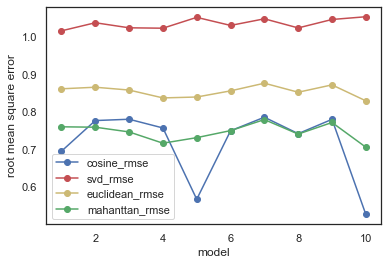

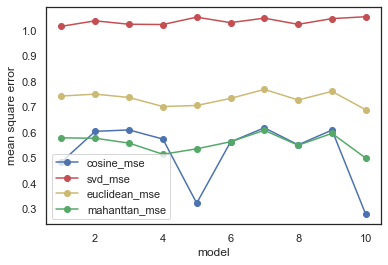

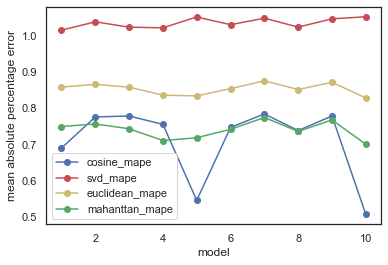

In [19]:
plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_rmse,'b',label='cosine_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_rmse,'r',label='svd_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_rmse,'y',label='euclidean_rmse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_rmse,'g',label='mahanttan_rmse', marker = 'o')

plt.legend()
plt.xlabel('model')
plt.ylabel('root mean square error')
plt.show()

plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_mse,'b',label='cosine_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_mse,'r',label='svd_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_mse,'y',label='euclidean_mse', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_mse,'g',label='mahanttan_mse', marker = 'o')

plt.legend()
plt.xlabel('model')
plt.ylabel('mean square error')
plt.show()


plt.plot([i+1 for i in range(len(cosine_rmse))],cosine_mape,'b',label='cosine_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],svd_mape,'r',label='svd_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],euclidean_mape,'y',label='euclidean_mape', marker = 'o')
plt.plot([i+1 for i in range(len(cosine_rmse))],mahanttan_mape,'g',label='mahanttan_mape', marker = 'o')


plt.legend()
plt.xlabel('model')
plt.ylabel('mean absolute percentage error')
plt.show()

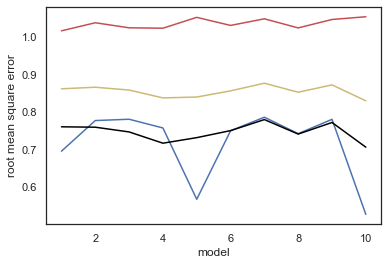

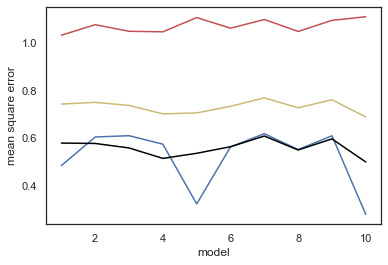

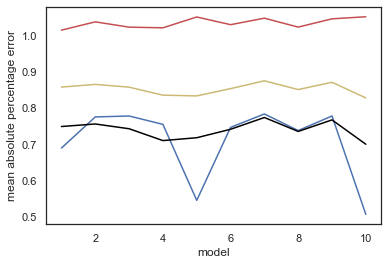

In [20]:
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m1,'b',label='rmse_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m2,'r',label='rmse_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m3,'y',label='rmse_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],rmse_m5,'black',label='rmse_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('root mean square error')
plt.show()

plt.plot([i+1 for i in range(len(rmse_m1))],mse_m1,'b',label='mse_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m2,'r',label='mse_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m3,'y',label='mse_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],mse_m5,'black',label='mse_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('mean square error')
plt.show()


plt.plot([i+1 for i in range(len(rmse_m1))],mape_m1,'b',label='mape_m1')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m2,'r',label='mape_m2')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m3,'y',label='mape_m3')
plt.plot([i+1 for i in range(len(rmse_m1))],mape_m5,'black',label='mape_m5')
# plt.legend()
plt.xlabel('model')
plt.ylabel('mean absolute percentage error')
plt.show()

In [21]:
a=cosine_rmse
b=svd_rmse
c=euclidean_rmse
d=mahanttan_rmse

print(a)
print(b)
print(c)
print(d)

[0.6953649078855352, 0.7770845024618189, 0.780585668512079, 0.7573247951206141, 0.5671896747291695, 0.7497388409781603, 0.7859771375557395, 0.7421414636473858, 0.7803406582944404, 0.5268156282320954]
[1.0163207283660998, 1.0378813734165997, 1.024394248095802, 1.023312461289565, 1.0522459065408456, 1.0307237491416616, 1.048370665870532, 1.024072354941604, 1.046588894799739, 1.0538851546567645]
[0.8617295400749869, 0.8659436971717805, 0.8584216896955621, 0.8374608525053387, 0.8398384959011563, 0.8562312879201931, 0.8766919034236634, 0.8526018426976758, 0.872194137612309, 0.8296939620178831]
[0.7604238781061531, 0.7593718150712995, 0.7467554076163515, 0.7167275307972684, 0.7315212506242157, 0.7502686062928038, 0.7796675135051456, 0.7410308383723391, 0.7719310207582305, 0.7060788549615042]


In [22]:
a=cosine_mse
b=svd_mse
c=euclidean_mse
d=mahanttan_mse

print(a)
print(b)
print(c)
print(d)

[0.4835323551186588, 0.6038603239663327, 0.6093139858864492, 0.5735408453044802, 0.32170412711938107, 0.5621083296712752, 0.6177600607603139, 0.550773952064684, 0.6089315429874006, 0.2775347061495773]
[1.0163207283660998, 1.0378813734165997, 1.024394248095802, 1.023312461289565, 1.0522459065408456, 1.0307237491416616, 1.048370665870532, 1.024072354941604, 1.046588894799739, 1.0538851546567645]
[0.7425778002378486, 0.7498584866715323, 0.7368877973397839, 0.7013406794789688, 0.7053286991975165, 0.7331320184134725, 0.768588693528606, 0.7269299021714724, 0.7607226136852795, 0.6883920706089326]
[0.5782444743940016, 0.5766455535246798, 0.5576436388042633, 0.5136983534027493, 0.5351233401148165, 0.5629029815885462, 0.6078814316152964, 0.5491267034188116, 0.5958775008088436, 0.49854734942374895]


In [23]:
a5=cosine_mape
b5=svd_mape
c5=euclidean_mape
d5=mahanttan_mape

print(a5)
print(b5)
print(c5)
print(d5)

[0.689596083639124, 0.7752626774027687, 0.7778415390150478, 0.7547792037244327, 0.5456176145423268, 0.7464963533444408, 0.7834891675130852, 0.7377925209929063, 0.7778860616164832, 0.5069306092592702]
[1.014157304095373, 1.037009271755825, 1.0223895914123944, 1.0206042411452527, 1.0504090068150815, 1.0292085931176695, 1.0470740956163436, 1.0225415871347814, 1.0453016691810362, 1.0510594647581677]
[0.8574249496095606, 0.8648474230610533, 0.8571989859443937, 0.835213169128545, 0.8331540143049412, 0.8531468796549119, 0.8747397332127368, 0.8506662103789426, 0.8706278296356875, 0.8275870839577344]
[0.7488840190812625, 0.7558847513857465, 0.7427582800118538, 0.7102010773491075, 0.7180237958975846, 0.7412620508556858, 0.7736914265552057, 0.7353591501928619, 0.7671033947368968, 0.7001067558908874]
